In [ ]:
import pyhf

In [1]:
import glob, json, re
import matplotlib.pyplot as plt
import numpy as np
import pyhf
from pyhf.contrib.viz import brazil

def parse_index(fname):
    match = re.search(r"extracted_data_(\d+)\.json", fname)
    return int(match.group(1))

# Filter files to include only those matching the pattern
json_files = [f for f in glob.glob("extracted_data_*.json") 
             if re.match(r"extracted_data_\d+\.json", f)]
json_files.sort(key=parse_index)  # numeric sort

def rebin(data, newbinsize):
    output = []
    i = 0
    while i < len(data):
        s = 0
        for _ in range(newbinsize):
            if i < len(data):
                s += data[i]
                i += 1
        output.append(s)
    return output

results = []

for idx, json_file in enumerate(json_files):
    print(f"\n=== Processing file index {idx}, name={json_file} ===")

    # Read the JSON
    with open(json_file,"r") as f:
        data = json.load(f)
        m_N2 = data["m_N2"]
        delta_m = data["delta_m"]
    
    signal_counts = data["hist_photon_energy_signal"]["entries"]
    background_counts = data["hist_photon_energy_BG"]["entries"]

    # Rebin
    signal_counts = rebin(signal_counts, 10)
    background_counts = rebin(background_counts, 10)

    total_signal = sum(signal_counts)
    total_bkg = sum(background_counts)
    if total_bkg > 0:
        significance = total_signal / np.sqrt(total_bkg)
        poi_max = max(3.0, 3 * significance)
    else:
        poi_max = 3.0
    poi_vals = np.linspace(0, poi_max, 50)

    # Debug check
    print("  signal[:5] =", signal_counts[:5], "sum=", sum(signal_counts))
    print("  background[:5] =", background_counts[:5], "sum=", sum(background_counts))

    # S+B
    signal_plus_bkg = [0.1*s + b for s,b in zip(signal_counts, background_counts)]
    # bkg_unc = [np.sqrt(b) + 0.1*b for b in background_counts]
    bkg_unc = [np.sqrt(max(b, 0)) + 0.1 * b for b in background_counts]

    # Build model & fit
    model = pyhf.simplemodels.uncorrelated_background(
        signal=signal_counts,
        bkg=background_counts,
        bkg_uncertainty=bkg_unc)
    observations = signal_plus_bkg + model.config.auxdata

    # try:
    #     obs_lim, exp_lims, (scan, pyhf_results) = pyhf.infer.intervals.upper_limits.upper_limit(
    #         observations, 
    #         model, 
    #         poi_vals, 
    #         level=0.05, 
    #         return_results=True,
    #         maxiter=10000,
    #         tolerance=1e-6
    #     )
    # except Exception as e:
    #     print(f"Fit failed for {json_file}: {e}")
    #     continue

    #Quick fit
    fit_result= pyhf.infer.mle.fit(
        observations, 
        model, 
        #maxiter=10000, 
        tolerance=1e-6
    )
    
    print("fit result =", fit_result)


    # Before fitting
    if sum(signal_counts) == 0 or sum(background_counts) == 0:
        print(f"Skipping {json_file} - empty histogram")
        continue

    # Quick upper-limit
    # poi_vals = np.linspace(0, 10, 10)

    max_signal = max(signal_counts)
    max_bkg = max(background_counts)
    poi_max = max(2.0, 1.5 * (max_signal + max_bkg) / max_bkg)  # SELF ADAPTIVE
    poi_vals = np.linspace(0, poi_max, 50)
    
    obs_lim, exp_lims, (scan, pyhf_results) = pyhf.infer.intervals.upper_limits.upper_limit(
        observations, model, poi_vals, level=0.05, return_results=True
    )
    print(f"  obs limit = {obs_lim:.3f}, exp limit central= {exp_lims[2]:.3f}")

    # Store results with explicit type conversion
    results.append({
        "m_N2": float(m_N2),  # Convert to Python float
        "delta_m": float(delta_m),
        "obs_limit": float(obs_lim),  # Handle NaN explicitly
        "exp_limits": [float(val) for val in exp_lims] 
    })

    # Plotting (optional)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_title(f"Brazil band: m_N2={m_N2} GeV, Δm={delta_m} GeV")
    brazil.plot_results(poi_vals, pyhf_results, ax=ax, smooth=True)

    
    # Handle NaN in observed limit
    valid_obs_lim = obs_lim if not np.isnan(obs_lim) else 0
    
    # Calculate dynamic ranges using EXPECTED limits if observed is NaN
    max_limit = max(exp_lims) if np.isnan(obs_lim) else max(obs_lim, max(exp_lims))
    min_limit = min(exp_lims) if np.isnan(obs_lim) else min(exp_lims[0], valid_obs_lim)
    
    # Ensure numerical stability
    xmax = 1.3 * max_limit if np.isfinite(max_limit) else 10  # Fallback range
    xmin = max(0, 0.7 * min_limit) if np.isfinite(min_limit) else 0

    # Set axis limits with validation
    # ax.set_xlim(float(xmin), float(xmax))
    ax.set_xlim(0, 1.2 * obs_lim if not np.isnan(obs_lim) else poi_max)
    ax.set_ylim(0, 1.5 * obs_lim if not np.isnan(obs_lim) else 5)
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Smart tick spacing
    tick_base = max(1, round((xmax - xmin)/5, 2))
    ax.xaxis.set_major_locator(plt.MultipleLocator(tick_base))
    
    plt.tight_layout()
    plt.savefig(f"BrazilBand_{idx}.png")
    plt.close()

# Save all results to a new file
with open("fit_results.json", "w") as f:
    json.dump(results, f, indent=2)



=== Processing file index 0, name=extracted_data_0.json ===
  signal[:5] = [198565.70678710938, 21508.71337890625, 12698.21728515625, 10160.114624023438, 7898.050537109375] sum= 277247.0807495117
  background[:5] = [111714.29663085938, 363401.5, 270438.15625, 203092.755859375, 149216.427734375] sum= 1463905.7504882812
fit result = [0.90615307 0.90123913 0.95508573 0.95528162 0.95582622 0.95623553
 0.95665495 0.95680199 0.95694222 0.95696811 0.95697094]
  obs limit = 1.415, exp limit central= 0.124

=== Processing file index 1, name=extracted_data_1.json ===
  signal[:5] = [91124.02868652344, 15792.835693359375, 11859.227783203125, 9392.512329101562, 8494.861450195312] sum= 160002.45804166794
  background[:5] = [111714.29663085938, 363401.5, 270438.15625, 203092.755859375, 149216.427734375] sum= 1463905.7504882812
fit result = [0.09985746 1.00011459 1.00000604 1.00000576 1.00000611 1.00000671
 1.00001026 1.00001094 1.00001165 1.00000795 1.00000226]
  obs limit = 0.308, exp limit centra

/home/phoenix666/fcck2/lib/python3.12/site-packages/pyhf/infer/calculators.py:418: RuntimeWarning: divide by zero encountered in scalar divide
  teststat = (qmu - qmu_A) / (2 * self.sqrtqmuA_v)
/home/phoenix666/fcck2/lib/python3.12/site-packages/pyhf/infer/calculators.py:467: RuntimeWarning: invalid value encountered in divide
  CLs = tensorlib.astensor(CLsb / CLb)


  obs limit = 2.000, exp limit central= 2.000

=== Processing file index 29, name=extracted_data_29.json ===
  signal[:5] = [6.168867018073797, 0.0, 0.0, 0.0, 0.0] sum= 6.168867018073797
  background[:5] = [111714.29663085938, 363401.5, 270438.15625, 203092.755859375, 149216.427734375] sum= 1463905.7504882812
fit result = [1.00000124 0.99995033 1.         1.         1.         0.99999969
 1.         1.         1.00000048 0.99999993 0.99999999]
  obs limit = 2.000, exp limit central= 2.000


check the fit configurtation

change the x axis to ph_E


cut before 12

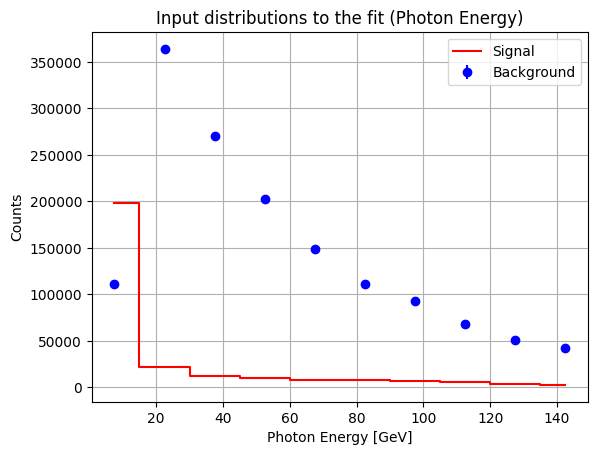

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open("extracted_data_0.json") as f:
    data = json.load(f)

bins_phE = np.array(data['hist_photon_energy_signal']['bins'])
sig_counts = np.array(data['hist_photon_energy_signal']['entries'])
bkg_counts = np.array(data['hist_photon_energy_BG']['entries'])

# Optional: rebin if needed
factor = 10
bins_phE_rb = bins_phE[:len(bins_phE)//factor*factor].reshape(-1, factor).mean(axis=1)
sig_rb = sig_counts[:len(sig_counts)//factor*factor].reshape(-1, factor).sum(axis=1)
bkg_rb = bkg_counts[:len(bkg_counts)//factor*factor].reshape(-1, factor).sum(axis=1)

plt.errorbar(bins_phE_rb, bkg_rb, yerr=np.sqrt(bkg_rb), fmt='o', color='blue', label='Background')
plt.step(bins_phE_rb, sig_rb, where='mid', color='red', label='Signal')

plt.xlabel("Photon Energy [GeV]")
plt.ylabel("Counts")
plt.title("Input distributions to the fit (Photon Energy)")
plt.legend()
plt.grid()
plt.show()


In [35]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Optional: output folder for plots
os.makedirs("photon_energy_plots", exist_ok=True)

def rebin(array, factor):
    """Utility to rebin 1D array by summing every `factor` bins."""
    n = (len(array) // factor) * factor
    return array[:n].reshape(-1, factor).sum(axis=1)

def rebin_mean(array, factor):
    """Utility to rebin x-axis (e.g., bin centers) by averaging."""
    n = (len(array) // factor) * factor
    return array[:n].reshape(-1, factor).mean(axis=1)

n_files = 30
rebin_factor = 10

for idx in range(n_files):
    filename = f"extracted_data_{idx}.json"
    if not os.path.exists(filename):
        print(f"File {filename} not found — skipping.")
        continue

    with open(filename) as f:
        data = json.load(f)

    # extract photon energy bins & counts
    bins_phE = np.array(data['hist_photon_energy_signal']['bins'])
    sig_counts = np.array(data['hist_photon_energy_signal']['entries'])
    bkg_counts = np.array(data['hist_photon_energy_BG']['entries'])

    # rebin if needed
    bins_rb = rebin_mean(bins_phE, rebin_factor)
    sig_rb = rebin(sig_counts, rebin_factor)
    bkg_rb = rebin(bkg_counts, rebin_factor)

    # error bars: Poisson uncertainty
    bkg_err = np.sqrt(bkg_rb)

    # plot
    plt.figure(figsize=(8, 5))
    plt.errorbar(bins_rb, bkg_rb, yerr=bkg_err, fmt='o', color='blue', label='Background')
    plt.step(bins_rb, sig_rb, where='mid', color='red', label='Signal')
    plt.xlabel("Photon Energy [GeV]")
    plt.ylabel("Counts")
    plt.title(f"Input distributions to the fit — Signal File #{idx}")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    outpath = f"photon_energy_plots/photon_energy_{idx}.png"
    plt.savefig(outpath, dpi=150)
    plt.close()

    print(f"Saved: {outpath}")

print("All plots generated in folder: photon_energy_plots/")


Saved: photon_energy_plots/photon_energy_0.png
Saved: photon_energy_plots/photon_energy_1.png
Saved: photon_energy_plots/photon_energy_2.png
Saved: photon_energy_plots/photon_energy_3.png
Saved: photon_energy_plots/photon_energy_4.png
Saved: photon_energy_plots/photon_energy_5.png
Saved: photon_energy_plots/photon_energy_6.png
Saved: photon_energy_plots/photon_energy_7.png
Saved: photon_energy_plots/photon_energy_8.png
Saved: photon_energy_plots/photon_energy_9.png
Saved: photon_energy_plots/photon_energy_10.png
Saved: photon_energy_plots/photon_energy_11.png
Saved: photon_energy_plots/photon_energy_12.png
Saved: photon_energy_plots/photon_energy_13.png
Saved: photon_energy_plots/photon_energy_14.png
Saved: photon_energy_plots/photon_energy_15.png
Saved: photon_energy_plots/photon_energy_16.png
Saved: photon_energy_plots/photon_energy_17.png
Saved: photon_energy_plots/photon_energy_18.png
Saved: photon_energy_plots/photon_energy_19.png
Saved: photon_energy_plots/photon_energy_20.png
Sa

In [2]:
# import glob, json, re
# import matplotlib.pyplot as plt
# import numpy as np
# import pyhf
# from pyhf.contrib.viz import brazil

# def parse_index(fname):
#     match = re.search(r"extracted_data_(\d+)\.json", fname)
#     return int(match.group(1))

# # Filter files to include only those matching the pattern
# json_files = [f for f in glob.glob("extracted_data_*.json") 
#              if re.match(r"extracted_data_\d+\.json", f)]
# json_files.sort(key=parse_index)  # numeric sort

# def rebin(data, newbinsize):
#     output = []
#     i = 0
#     while i < len(data):
#         s = 0
#         for _ in range(newbinsize):
#             if i < len(data):
#                 s += data[i]
#                 i += 1
#         output.append(s)
#     return output

# results = []  # This will store all mass points and their limits

# for idx, json_file in enumerate(json_files):
#     print(f"\n=== Processing file index {idx}, name={json_file} ===")

#     # 1) Read the JSON
#     with open(json_file,"r") as f:
#         data = json.load(f)
#         m_N2 = data["m_N2"]
#         delta_m = data["delta_m"]

#     # 2) Process histograms
#     signal_counts = data["hist_photon_energy_signal"]["entries"]
#     background_counts = data["hist_photon_energy_BG"]["entries"]
    
#     # Rebin histograms
#     signal_counts = rebin(signal_counts, 10)
#     background_counts = rebin(background_counts, 10)

#     # 3) Build model & fit
#     model = pyhf.simplemodels.uncorrelated_background(
#         signal=signal_counts,
#         bkg=background_counts,
#         bkg_uncertainty=[np.sqrt(b) + 0.1*b for b in background_counts]
#     )
#     observations = [0.1*s + b for s, b in zip(signal_counts, background_counts)] + model.config.auxdata

#     # Skip empty histograms
#     if sum(signal_counts) == 0 or sum(background_counts) == 0:
#         print(f"Skipping {json_file} - empty histogram")
#         continue

#     # 4) Calculate upper limits
#     poi_vals = np.linspace(0, 10, 10)
#     obs_lim, exp_lims, (scan, pyhf_results) = pyhf.infer.intervals.upper_limits.upper_limit(
#         observations, model, poi_vals, level=0.05, return_results=True
#     )
#     print(f"  obs limit = {obs_lim:.3f}, exp limit central= {exp_lims[2]:.3f}")

#     # 5) Store results (convert numpy types to Python types)
#     results.append({
#         "m_N2": m_N2,
#         "delta_m": delta_m,
#         "obs_limit": float(obs_lim),  # Convert numpy float to Python float
#         "exp_limits": [float(val) for val in exp_lims]  # Convert numpy array to list of Python floats
#     })

#     # 6) Plotting (optional)
#     fig, ax = plt.subplots(figsize=(8,5))
#     ax.set_title(f"Brazil band for {json_file}")
#     brazil.plot_results(poi_vals, pyhf_results, ax=ax)
    
#     # ... [rest of plotting code] ...
#     plt.close()

# # Save results to JSON
# with open("fit_results.json", "w") as f:
#     json.dump(results, f, indent=2, allow_nan=True)  # Explicitly allow NaN serialization

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

xsec_map = {
"test_Higgsino_100_50_simple": 0.07668,
"test_Higgsino_100_80_simple": 0.07298,
"test_Higgsino_100_90_simple": 0.07148,
"test_Higgsino_100_95_simple": 0.07070,
"test_Higgsino_100_98_simple": 0.07031,
"test_Higgsino_100_99_simple": 0.07023,
"test_Higgsino_120_70_simple": 0.05649,
"test_Higgsino_120_100_simple": 0.05303,
"test_Higgsino_120_110_simple": 0.05168,
"test_Higgsino_120_115_simple": 0.05096,
"test_Higgsino_120_118_simple": 0.05059,
"test_Higgsino_120_119_simple": 0.05045,
"test_Higgsino_140_90_simple": 0.03699,
"test_Higgsino_140_120_simple": 0.03331,
"test_Higgsino_140_130_simple": 0.03194,
"test_Higgsino_140_135_simple": 0.03131,
"test_Higgsino_140_138_simple": 0.03087,
"test_Higgsino_140_139_simple": 0.03071,
"test_Higgsino_160_110_simple": 0.01806,
"test_Higgsino_160_140_simple": 0.01411,
"test_Higgsino_160_150_simple": 0.01271,
"test_Higgsino_160_155_simple": 0.01201,
"test_Higgsino_160_158_simple": 0.01163,
"test_Higgsino_160_159_simple": 0.01149,
"test_Higgsino_180_130_simple": 0.004725,
"test_Higgsino_180_160_simple": 0.0009906,
"test_Higgsino_180_170_simple": 0.0001484,
"test_Higgsino_182_132_simple": 0.004181,
"test_Higgsino_182_162_simple": 0.0005962,
"test_Higgsino_182_172_simple": 0.000005557,
}


with open("fit_results.json", "r") as f:
    results = json.load(f)

# Create DataFrame for table
table_data = []
for idx, result in enumerate(results):
    # Get corresponding cross section using file index
    sigma = xsec_map.get(f"test_Higgsino_{int(result['m_N2'])}_{int(result['m_N2']-result['delta_m'])}_simple", np.nan)
    
    table_data.append({
        "m(χ₂⁰) [GeV]": result["m_N2"],
        "m(χ₁⁰) [GeV]": result["m_N2"] - result["delta_m"],
        "Δm [GeV]": result["delta_m"],
        "σ [pb]": sigma,
        "Expected μ": result["exp_limits"][2]  # Central expected limit
    })


df = pd.DataFrame(table_data)

# Display formatted table 
print("\nSummary Table:")
display(df.style
    .format({
        "m(χ₂⁰) [GeV]": "{:.0f}",
        "m(χ₁⁰) [GeV]": "{:.0f}",
        "Δm [GeV]": "{:.1f}",
        "σ [pb]": "{:.2e}",
        "Expected μ": "{:.2f}"
    })
    .set_caption("Higgsino Parameter Summary")
    .background_gradient(cmap='Blues', subset=["σ [pb]"])
)


# Sort data by m_N2
results_sorted = sorted(results, key=lambda x: x["m_N2"])
m_N2_values = [d["m_N2"] for d in results_sorted]
obs_limits = [d["obs_limit"] for d in results_sorted]
exp_limits = [d["exp_limits"] for d in results_sorted]

# Extract expected bands
exp_2sigma_low = [e[0] for e in exp_limits]
exp_1sigma_low = [e[1] for e in exp_limits]
exp_median = [e[2] for e in exp_limits]
exp_1sigma_high = [e[3] for e in exp_limits]
exp_2sigma_high = [e[4] for e in exp_limits]

# Format numerical values
pd.options.display.float_format = '{:.4f}'.format
df_clean = df.dropna()  # Remove any rows with missing values

# Create plot
plt.figure(figsize=(10, 6))
plt.fill_between(m_N2_values, exp_2sigma_low, exp_2sigma_high, color='lime', alpha=0.3, label="Expected ±2σ")
plt.fill_between(m_N2_values, exp_1sigma_low, exp_1sigma_high, color='yellow', alpha=0.5, label="Expected ±1σ")
plt.plot(m_N2_values, exp_median, 'k--', label="Expected median")

# Observed limit (filter out NaNs)
valid_indices = ~np.isnan(obs_limits)
plt.plot(np.array(m_N2_values)[valid_indices], np.array(obs_limits)[valid_indices], 'ro-', markersize=5, label="Observed")

# # Labels and styling
plt.xlabel(r"$m(\tilde{\chi}_2^0)$ [GeV]", fontsize=12)
plt.ylabel(r"95% CL Upper Limit on Signal Strength ($\mu$)", fontsize=12)
plt.title("Higgsino Exclusion Limits", fontsize=14)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.3)
plt.yscale('log')  # Use if limits vary exponentially
plt.xlim(min(m_N2_values)-10, max(m_N2_values)+10)
plt.tight_layout()

plt.savefig("Higgsino_Exclusion_Limits.png", dpi=300)
plt.show()


#Style table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.tight_layout()
plt.savefig("Higgsino_Exclusion_Limits_with_Table.png", dpi=300, bbox_inches='tight')
plt.show()

# save table as CSV
df_clean.to_csv("Higgsino_Results_Table.csv", index=False)

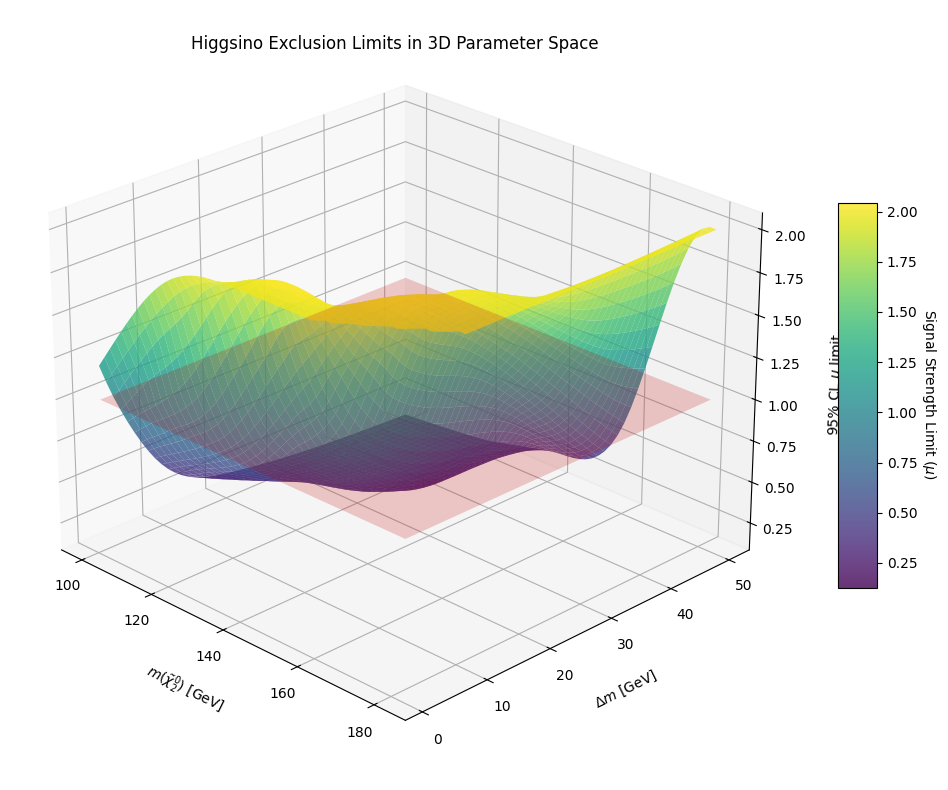

In [36]:
import json
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

with open("fit_results.json", "r") as f:
    results = json.load(f)

# Extract data from results
m_chi2 = [d['m_N2'] for d in results]          # <-- DEFINE THESE VARIABLES
delta_m = [d['delta_m'] for d in results]
mu_limits = [d['exp_limits'][2] for d in results]

# Create 3D figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create grid coordinates
xi = np.linspace(min(m_chi2), max(m_chi2), 50)
yi = np.linspace(min(delta_m), max(delta_m), 50)
xi, yi = np.meshgrid(xi, yi)

# Interpolate z-values onto grid
zi = griddata((m_chi2, delta_m), mu_limits, (xi, yi), method='cubic')

# Create surface plot
surf = ax.plot_surface(xi, yi, zi, cmap='viridis', 
                      edgecolor='none', alpha=0.8)

# Add contour projections
ax.contour(xi, yi, zi, 10, offset=zi.min(), 
          cmap='viridis', linestyles='solid')

# Customize labels
ax.set_xlabel(r'$m(\tilde{\chi}_2^0)$ [GeV]', labelpad=12)
ax.set_ylabel(r'$\Delta m$ [GeV]', labelpad=12)
ax.set_zlabel(r'95% CL $\mu$ limit', labelpad=12)

# Add color bar
cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
cbar.set_label(r'Signal Strength Limit ($\mu$)', rotation=270, labelpad=15)

# Set viewing angle
ax.view_init(elev=25, azim=-45)

# Add grid
ax.grid(True, alpha=0.3)

# Add title
plt.title("Higgsino Exclusion Limits in 3D Parameter Space", y=1.02)

# Highlight exclusion region (μ < 1)
ax.azim = -45
ax.dist = 10
ax.elev = 25

# Add plane at μ=1 for reference
xx, yy = np.meshgrid(np.linspace(min(m_chi2), max(m_chi2)),  # <-- CHANGE x to m_chi2
                     np.linspace(min(delta_m), max(delta_m))) # <-- CHANGE y to delta_m
ax.plot_surface(xx, yy, np.ones_like(xx), color='red', alpha=0.2)

plt.tight_layout()
plt.savefig("3D_Higgsino_Exclusion.png", dpi=300, bbox_inches='tight')
plt.show()

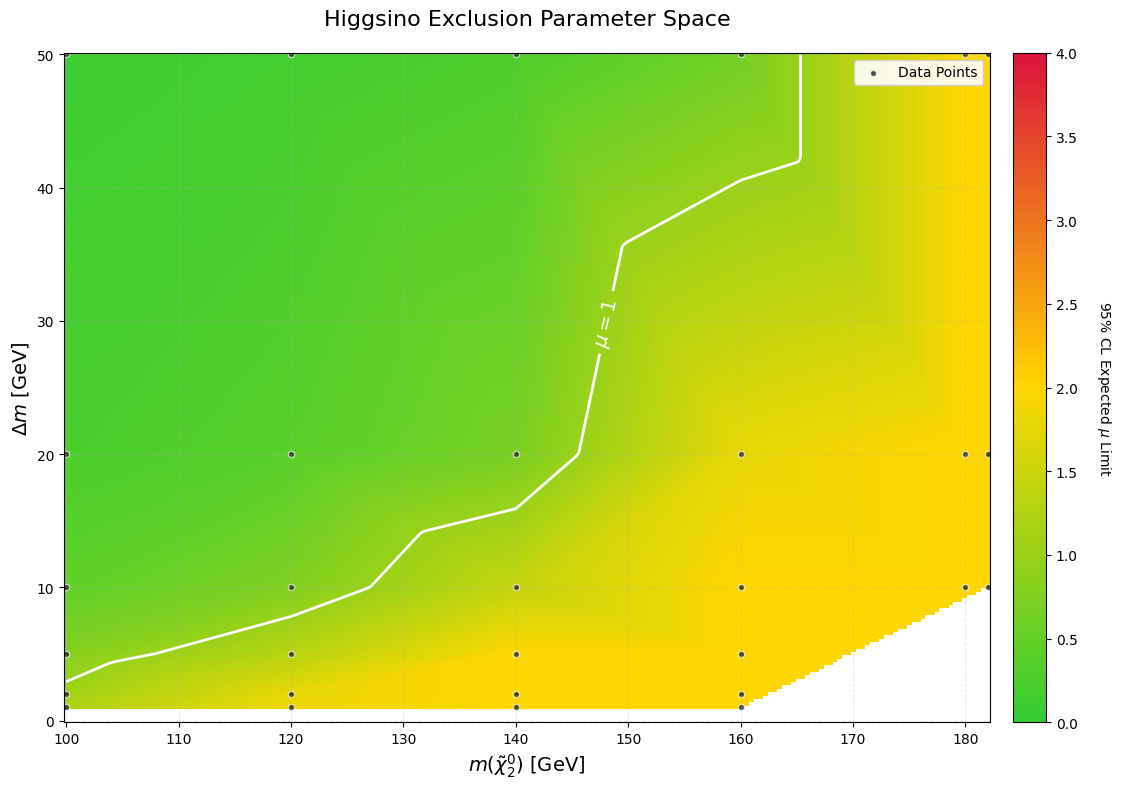

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# 加载数据
with open("fit_results.json", "r") as f:
    results = json.load(f)

# 提取数据
m_chi2 = np.array([d['m_N2'] for d in results])
delta_m = np.array([d['delta_m'] for d in results])
mu_vals = np.array([d['exp_limits'][2] for d in results])

# 创建插值网格
xi = np.linspace(min(m_chi2), max(m_chi2), 200)
yi = np.linspace(0, max(delta_m), 200)  # 从0开始更合理
xi, yi = np.meshgrid(xi, yi)

# 使用线性插值保证稳定性
zi = griddata((m_chi2, delta_m), mu_vals, (xi, yi), method='linear')

# 创建图形
plt.figure(figsize=(12, 8))

# 定义自定义颜色映射
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, "limegreen"), (0.5, "gold"), (1, "crimson")]
cmap = LinearSegmentedColormap.from_list("custom", colors, N=256)

# 绘制热图
heatmap = plt.pcolormesh(xi, yi, zi, 
                        cmap=cmap,
                        shading='auto',
                        vmin=0, 
                        vmax=4)  # 扩展上限到4

# 添加μ=1的等高线
cs = plt.contour(xi, yi, zi, levels=[1], 
                colors='white', linewidths=2)
plt.clabel(cs, inline=True, fmt=r'$\mu=1$', fontsize=14)

# 添加数据点标记
plt.scatter(m_chi2, delta_m, c='black', s=20, 
           edgecolors='white', label='Data Points', alpha=0.7)

# 添加颜色条
cbar = plt.colorbar(heatmap, pad=0.02)
cbar.set_label(r'95% CL Expected $\mu$ Limit', rotation=270, labelpad=25)

# 坐标轴设置
plt.xlabel(r'$m(\tilde{\chi}_2^0)$ [GeV]', fontsize=14)
plt.ylabel(r'$\Delta m$ [GeV]', fontsize=14)
plt.title("Higgsino Exclusion Parameter Space", fontsize=16, pad=20)

# 优化网格和布局
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='upper right', framealpha=0.9)
plt.tight_layout()

# 保存并显示
plt.savefig("Higgsino_Heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

In [38]:
top_left_index = np.argmax(delta_m - m_chi2)
m_top = m_chi2[top_left_index]
dm_top = delta_m[top_left_index]
mu_top = mu_vals[top_left_index]

print(f"Top-left point: m_chi2 = {m_top}, delta_m = {dm_top}, mu = {mu_top}")


Top-left point: m_chi2 = 100.0, delta_m = 50.0, mu = 0.12448459284852757


In [39]:
excluded_idx = np.where(mu_vals < 1)[0]
not_excluded_idx = np.where(mu_vals >= 1)[0]


In [40]:
import json
import matplotlib.pyplot as plt

def load_photon_hist(idx):
    with open(f"extracted_data_{idx}.json") as f:
        data = json.load(f)
    bins = data['hist_photon_energy_signal']['bins']
    entries = data['hist_photon_energy_signal']['entries']
    return bins, entries


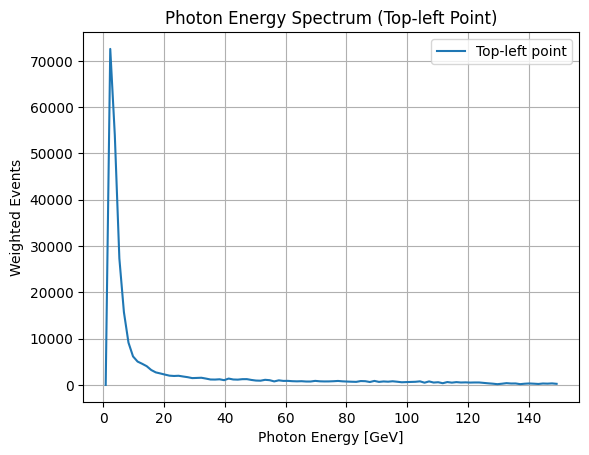

In [41]:
bins, entries = load_photon_hist(top_left_index)
plt.plot(bins, entries, label="Top-left point")
plt.xlabel("Photon Energy [GeV]")
plt.ylabel("Weighted Events")
plt.title("Photon Energy Spectrum (Top-left Point)")
plt.grid(True)
plt.legend()
plt.show()


Strong low-energy photon peak, very high total photon count
Similar shape, but lower total photon yield on average
~1.28 → not excluded, even though it looks "signal-rich"
ISR-like (Initial State Radiation) photon spectrum



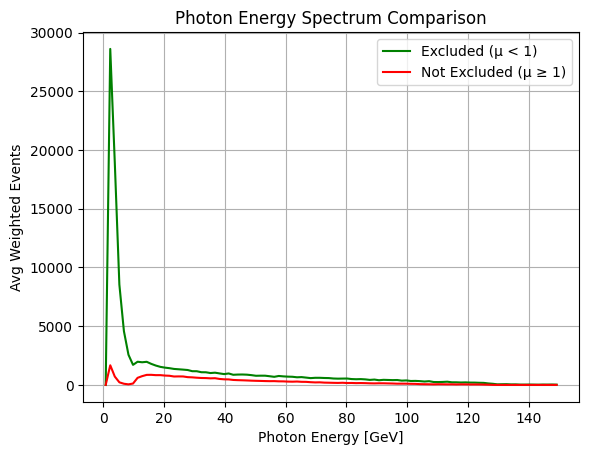

In [42]:
def average_hist(indices):
    combined = None
    for idx in indices:
        bins, entries = load_photon_hist(idx)
        if combined is None:
            combined = np.array(entries)
        else:
            combined += np.array(entries)
    return bins, combined / len(indices)

bins_ex, avg_ex = average_hist(excluded_idx)
bins_nx, avg_nx = average_hist(not_excluded_idx)

plt.plot(bins_ex, avg_ex, label="Excluded (μ < 1)", color='green')
plt.plot(bins_nx, avg_nx, label="Not Excluded (μ ≥ 1)", color='red')
plt.xlabel("Photon Energy [GeV]")
plt.ylabel("Avg Weighted Events")
plt.title("Photon Energy Spectrum Comparison")
plt.legend()
plt.grid(True)
plt.show()


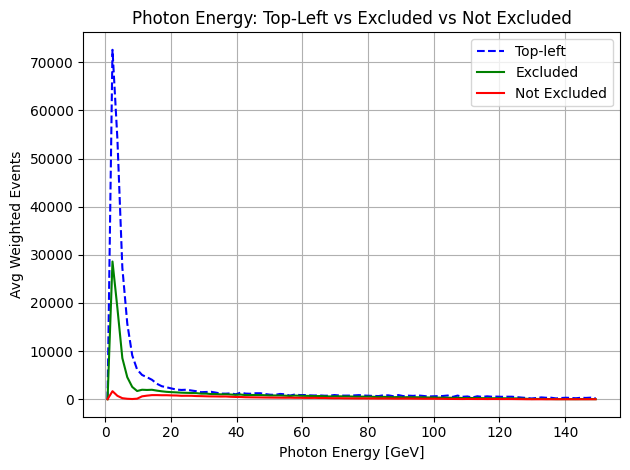

In [43]:
plt.plot(bins, entries, label="Top-left", color="blue", linestyle="--")
plt.plot(bins_ex, avg_ex, label="Excluded", color="green")
plt.plot(bins_nx, avg_nx, label="Not Excluded", color="red")
plt.xlabel("Photon Energy [GeV]")
plt.ylabel("Avg Weighted Events")
plt.title("Photon Energy: Top-Left vs Excluded vs Not Excluded")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
# check the top left point 
# check the plot for excluded points and non-excluded
# ph energy
# shape


# sllides show steps on contour
# plots on the way

In [24]:
# import matplotlib.pyplot as plt

# excluded = mu_vals < 1
# not_excluded = mu_vals >= 1

# plt.figure(figsize=(12, 8))

# # Plot the original heatmap
# plt.pcolormesh(xi, yi, zi, cmap=cmap, shading='auto', vmin=0, vmax=4)

# # μ=1 contour
# cs = plt.contour(xi, yi, zi, levels=[1], colors='white', linewidths=2)
# plt.clabel(cs, inline=True, fmt=r'$\mu=1$', fontsize=14)

# # Mark data points with classification
# plt.scatter(m_chi2[excluded], delta_m[excluded], color='green', label='Excluded (μ < 1)', edgecolors='white', s=50)
# plt.scatter(m_chi2[not_excluded], delta_m[not_excluded], color='red', label='Not Excluded (μ ≥ 1)', edgecolors='white', s=50)

# # Labels and formatting
# cbar = plt.colorbar(pad=0.02)
# cbar.set_label(r'95% CL Expected $\mu$ Limit', rotation=270, labelpad=25)
# plt.xlabel(r'$m(\tilde{\chi}_2^0)$ [GeV]', fontsize=14)
# plt.ylabel(r'$\Delta m$ [GeV]', fontsize=14)
# plt.title("Signal Classification in Higgsino Parameter Space", fontsize=16, pad=20)
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.tight_layout()
# plt.savefig("Higgsino_Signal_Classification.png", dpi=300)
# plt.show()


import matplotlib.pyplot as plt
import numpy as np

def plot_input_data(
    signal_data,
    background_data,
    variable_name="Photon Energy",
    bin_size=None,
    nbins=None,
    output_name="input_plot.png"
):
    """
    Plot the raw data for signal and background, letting matplotlib do the binning.
    
    Arguments:
        signal_data      : list or np.array of signal values
        background_data  : list or np.array of background values
        variable_name    : string for x-axis label
        bin_size         : if given, we'll build bin edges of that width
        nbins            : if given (and bin_size is None), we let matplotlib do that many bins
        output_name      : name of the output image file
    """
    plt.figure(figsize=(8, 6))

    if bin_size:
        # We'll figure out the range from both datasets
        data_min = min(min(signal_data), min(background_data))
        data_max = max(max(signal_data), max(background_data))
        bin_edges = np.arange(data_min, data_max + bin_size, bin_size)
        plt.hist(signal_data, bins=bin_edges, alpha=0.5, label="Signal")
        plt.hist(background_data, bins=bin_edges, alpha=0.5, label="Background")
    else:
        # If user did not provide bin_size, we can default to nbins or 50
        if not nbins:
            nbins = 50
        plt.hist(signal_data, bins=nbins, alpha=0.5, label="Signal")
        plt.hist(background_data, bins=nbins, alpha=0.5, label="Background")

    plt.xlabel(variable_name)
    plt.ylabel("Counts")
    plt.title("Signal vs Background")
    plt.legend()
    plt.grid(True, axis="y", alpha=0.75)
    plt.tight_layout()
    plt.savefig(output_name)
    plt.close()
    print(f"Saved input plot to {output_name}")
